# Imports

In [1]:
import os
import sys

sys.path.append("../src")
FIG_PATH = "../fig"

import itertools
import random
import time
from collections import defaultdict

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import text_flappy_bird_gym
from IPython.display import clear_output
from tqdm import tqdm

from agents import BaseAgent, SarsaAgent, SarsaNstepAgent, SarsaLambdaAgent
from plotting import plot_policy, plot_state_values

np.random.seed(42)
random.seed(42)

# SARSA Agent

![SARSA](../img/sarsa-on-policy-td-control-for-estimating-Q.png)


100%|██████████| 20000/20000 [00:10<00:00, 1883.73it/s]


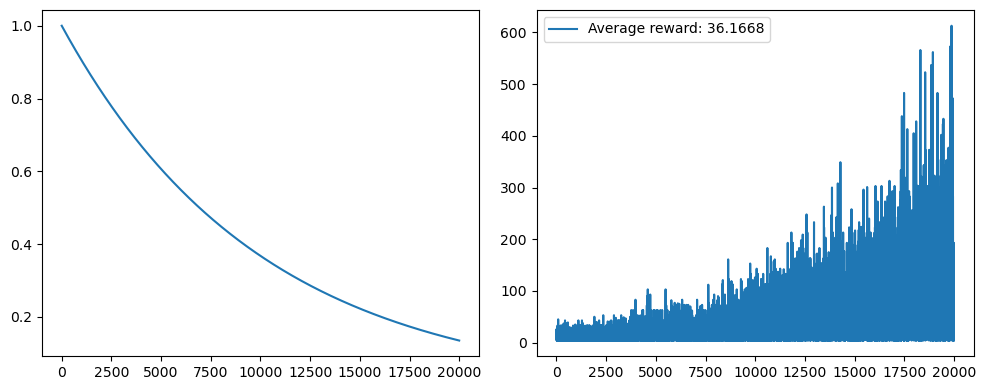

In [2]:
env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

sarsa_agent = SarsaAgent(
    env,
    alpha=0.02,
    gamma=0.9,
    epsilon=1.0,
    epsilon_decay=0.9999,
    epsilon_min=0.05,
)
epsilons, train_rewards = sarsa_agent.train(20_000, max_reward=5_000)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epsilons)

plt.subplot(1, 2, 2)
plt.plot(train_rewards, label=f"Average reward: {train_rewards.mean()}")
plt.legend()

plt.tight_layout()
plt.show()

100%|██████████| 1000/1000 [00:06<00:00, 165.54it/s]


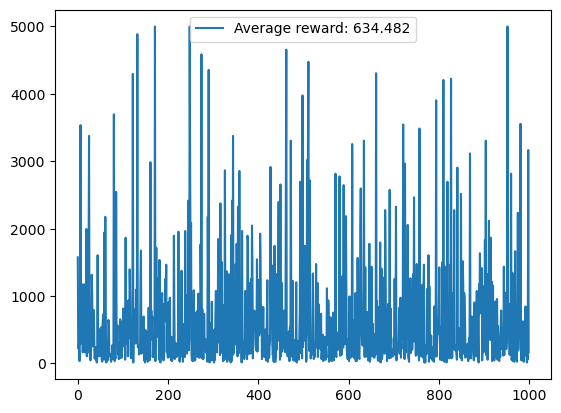

In [7]:
test_rewards = sarsa_agent.test(1_000, max_reward=5_000)

plt.plot(test_rewards, label=f"Average reward: {test_rewards.mean()}")
plt.legend()
plt.show()

### N-step SARSA

![N-step Sarsa](../img/n-step-sarsa-for-estimating-Q.png)


100%|██████████| 20000/20000 [00:22<00:00, 906.51it/s] 


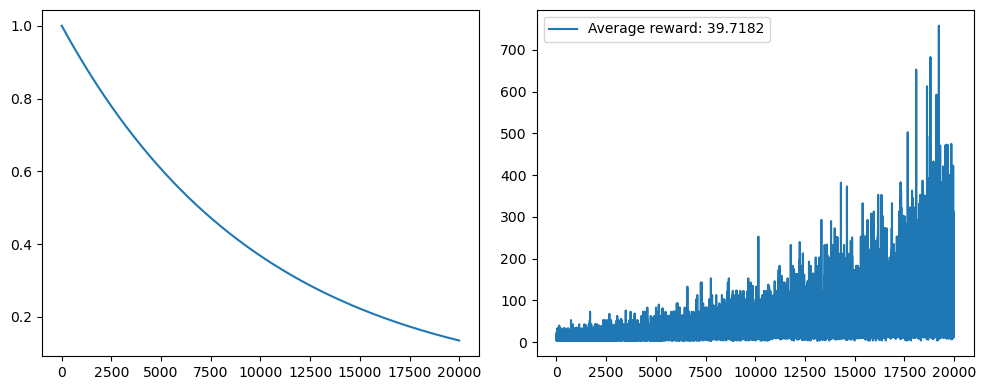

In [4]:
env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

sarsa_n_agent = SarsaNstepAgent(
    env,
    alpha=0.02,
    gamma=0.9,
    n=20,
    epsilon=1.0,
    epsilon_decay=0.9999,
    epsilon_min=0.05,
)
epsilons, train_rewards, train_lengths = sarsa_n_agent.train(20_000, max_reward=5_000)


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epsilons)

plt.subplot(1, 2, 2)
plt.plot(train_rewards, label=f"Average reward: {train_rewards.mean()}")
plt.legend()

plt.tight_layout()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:49<00:00, 20.13it/s]


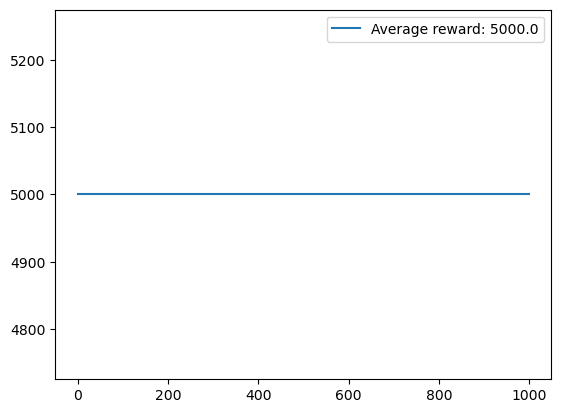

In [8]:
test_rewards = sarsa_n_agent.test(1_000, max_reward=5_000)

plt.plot(test_rewards, label=f"Average reward: {test_rewards.mean()}")
plt.legend()
plt.show()

### Lambda SARSA

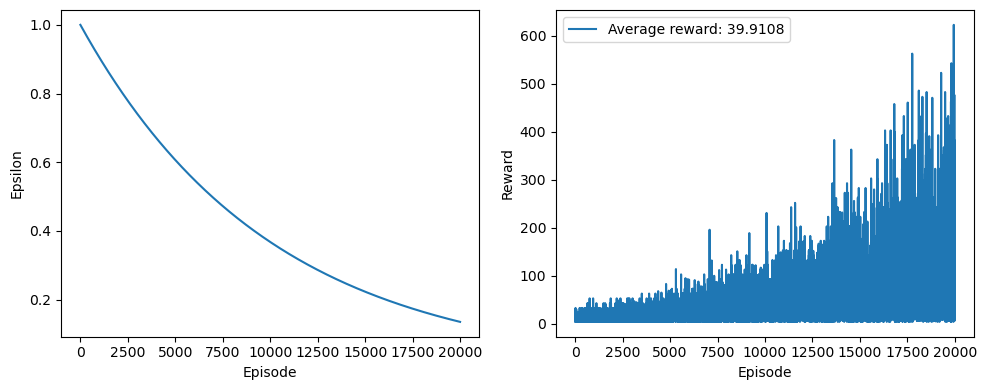

In [7]:
env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

sarsa_lambda_agent = SarsaLambdaAgent(
    env,
    alpha=0.02,
    gamma=0.9,
    lambd=0.5,
    epsilon=1.0,
    epsilon_decay=0.9999,
    epsilon_min=0.05,
)
train_epsilons, train_episode_rewards, train_episode_lengths = sarsa_lambda_agent.train(20_000, max_reward=5_000)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")

plt.subplot(1, 2, 2)
plt.plot(train_episode_rewards, label=f"Average reward: {np.mean(train_episode_rewards)}")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, "sarsa-train-simple-env.png"))

plt.show()

100%|██████████| 10000/10000 [08:14<00:00, 20.21it/s]


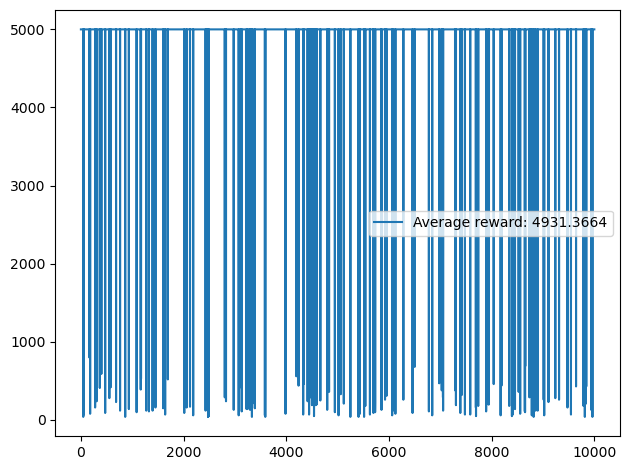

In [8]:
test_rewards = sarsa_lambda_agent.test(10_000, max_reward=5_000)

plt.plot(test_rewards, label=f"Average reward: {test_rewards.mean()}")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, "sarsa-test-simple-env.png"))
plt.show()

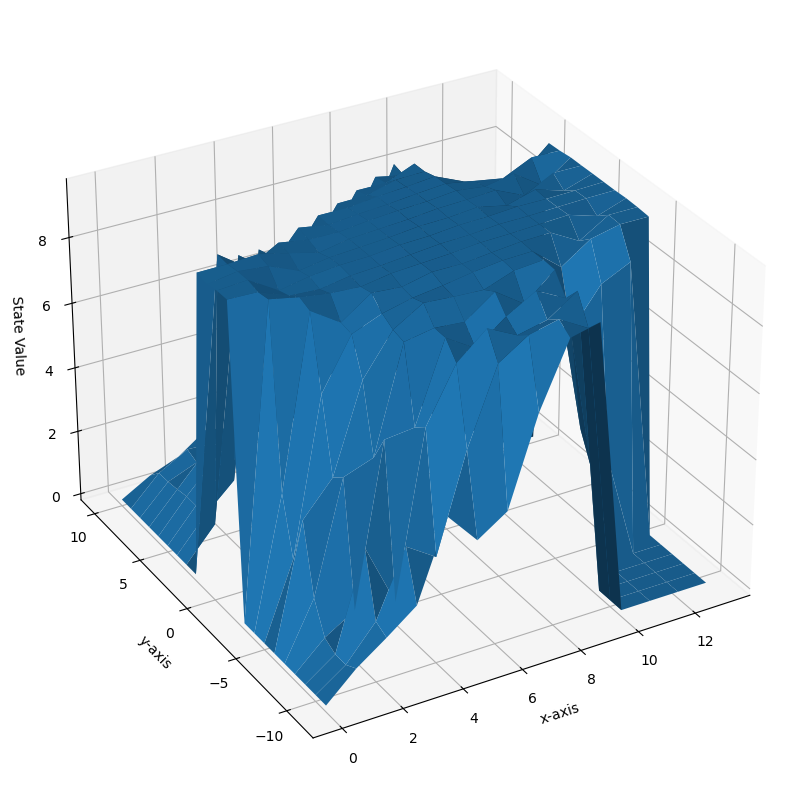

In [9]:
plot_state_values(
    sarsa_lambda_agent.Q,
    title="",
    save_file=os.path.join(FIG_PATH, "sarsa-state-values-simple-env.png"),
)

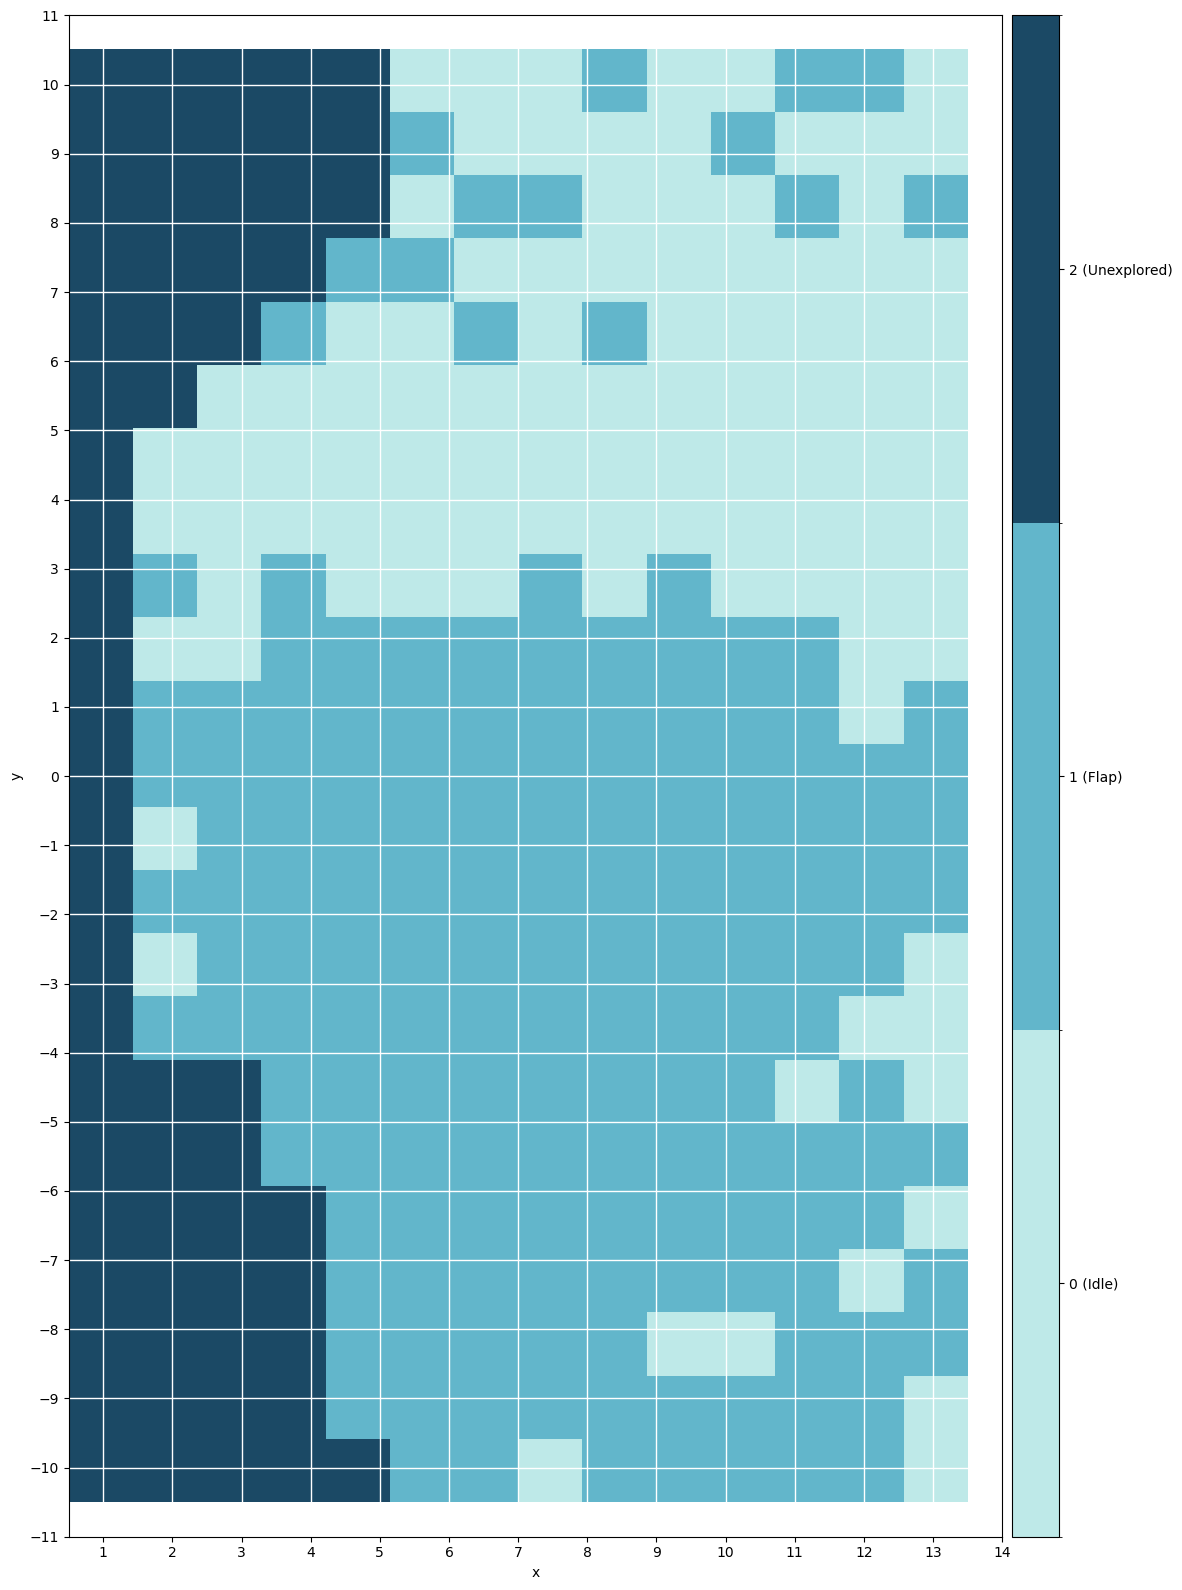

In [10]:
plot_policy(
    sarsa_lambda_agent.Q,
    title="",
    save_file=os.path.join(FIG_PATH, "sarsa-policy-simple-env.png"),
)

##### Parameter sweep

In [11]:
gammas = [0.9, 0.95, 0.99]
alphas = [0.02, 0.01, 0.001]
lambdas = [0.25, 0.5, 0.75]


In [14]:
best_params = None
best_reward = float('-inf')

env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

results = []

for gamma, alpha, lambd in itertools.product(gammas, alphas, lambdas):
    
    sarsa_lambda_agent = SarsaLambdaAgent(
        env,
        alpha=alpha,
        gamma=gamma,
        lambd=lambd,
        epsilon=1.0,
        epsilon_decay=0.9999,
        epsilon_min=0.1,
    )
    epsilons, episode_rewards, episode_lengths = sarsa_lambda_agent.train(5_000, max_reward=5_000)
    
    avg_reward = sum(episode_rewards) / len(episode_rewards)

    results.append({
        "gamma": gamma,
        "alpha": alpha, 
        "lambda": lambd,
        "avg_reward": avg_reward 
    })
    
    if avg_reward > best_reward:
        best_reward = avg_reward
        best_params = {'gamma': gamma, 'alpha': alpha, 'lambda': lambd}

results_df = pd.DataFrame(results)
results_df.sort_values(by="avg_reward", ascending=False).head()
results_df.to_csv("parameter-sweep-sarsa-simple-env.csv")

print("Best parameters:", best_params)
print("Best average reward:", best_reward)

100%|██████████| 5000/5000 [00:59<00:00, 83.39it/s] 

Best parameters: {'gamma': 0.99, 'alpha': 0.01, 'lambda': 0.75}
Best average reward: 15.0462


In [22]:
results_df.sort_values(by="avg_reward", ascending=False).head()

,gamma,alpha,lambda,avg_reward
23,0.99,0.01,0.75,15.0462
20,0.99,0.02,0.75,14.9884
11,0.95,0.02,0.75,14.8874
19,0.99,0.02,0.50,14.8538
14,0.95,0.01,0.75,14.6176


##### Best parameters

100%|██████████| 20000/20000 [09:42<00:00, 34.32it/s]


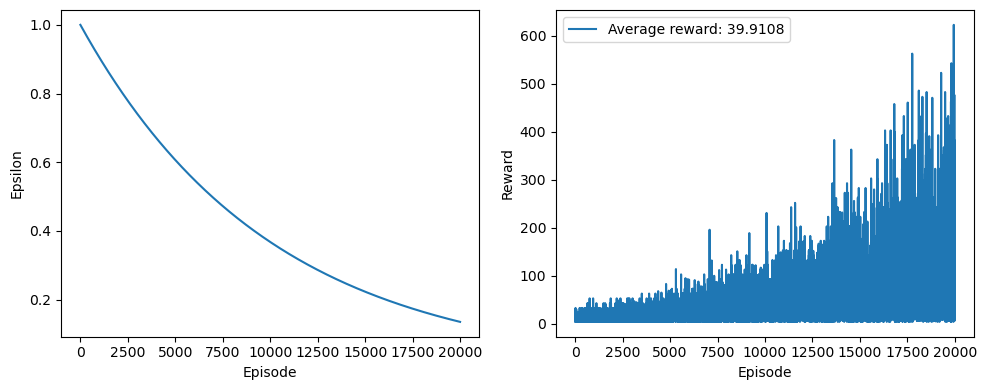

In [16]:
env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

sarsa_lambda_agent = SarsaLambdaAgent(
    env,
    alpha=0.01,
    gamma=0.99,
    lambd=0.75,
    epsilon=1.0,
    epsilon_decay=0.9999,
    epsilon_min=0.1,
)
epsilons, episode_rewards, episode_lengths = sarsa_lambda_agent.train(20_000, max_reward=5_000)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")

plt.subplot(1, 2, 2)
plt.plot(train_episode_rewards, label=f"Average reward: {np.mean(train_episode_rewards)}")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, "sarsa-train-best-simple-env.png"))

plt.show()

100%|██████████| 10000/10000 [07:38<00:00, 21.83it/s]


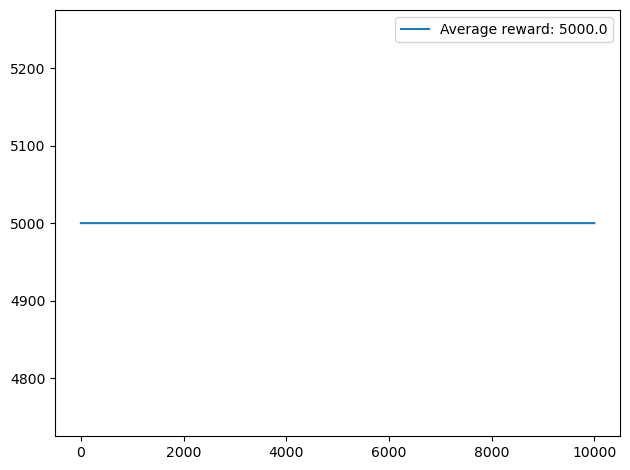

In [17]:
test_rewards = sarsa_lambda_agent.test(10_000, max_reward=5_000)

plt.plot(test_rewards, label=f"Average reward: {test_rewards.mean()}")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, "sarsa-test-best-simple-env.png"))
plt.show()

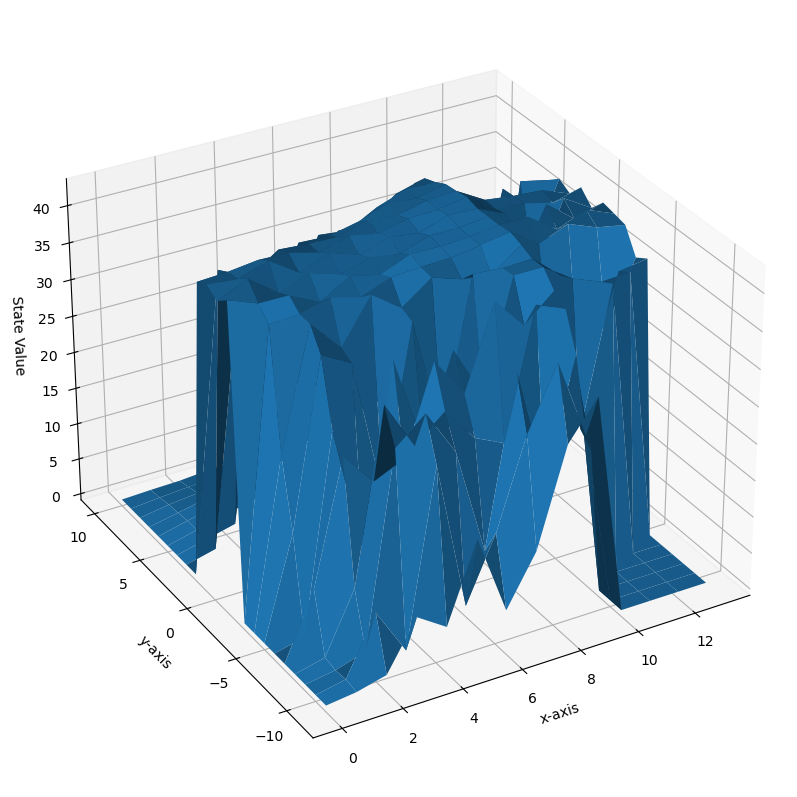

In [18]:
plot_state_values(
    sarsa_lambda_agent.Q,
    title="",
    save_file=os.path.join(FIG_PATH, "sarsa-state-values-best-simple-env.png"),
)

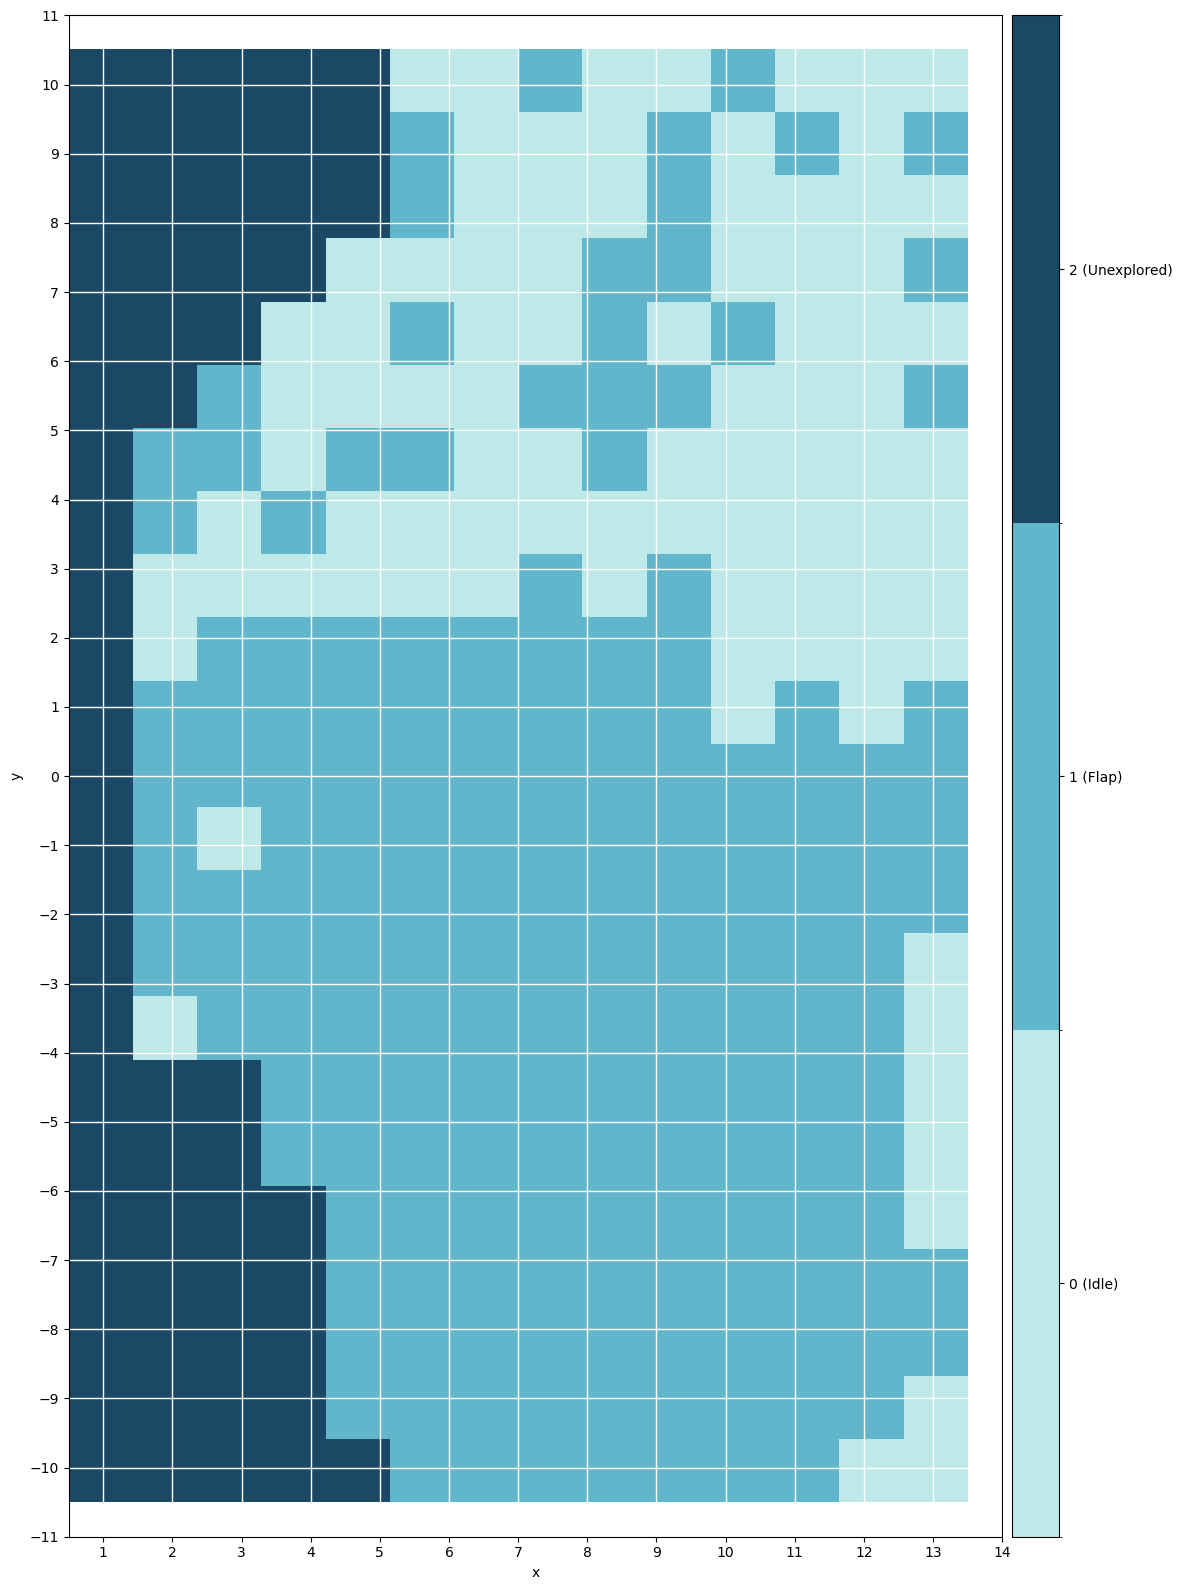

In [19]:
plot_policy(
    sarsa_lambda_agent.Q,
    title="",
    save_file=os.path.join(FIG_PATH, "sarsa-policy-best-simple-env.png"),
)

##### Environment sweep

In [20]:
heights = [12, 15, 18]
widths = [15, 20, 30]
pipe_gaps = [3, 4, 5]

In [21]:
env_sweep_results = []

for height, width, pipe_gap in itertools.product(heights, widths, pipe_gaps):
    
    env = gym.make("TextFlappyBird-v0", height=height, width=width, pipe_gap=pipe_gap)
    sarsa_lambda_agent.env = env
    rewards = sarsa_lambda_agent.test(1_000, max_reward=5_000)
    
    env_sweep_results.append({
        "height": height,
        "width": width, 
        "pipe_gap": pipe_gap,
        "avg_reward": rewards.mean() 
    })

env_sweep_results_df = pd.DataFrame(env_sweep_results)
env_sweep_results_df.to_csv("env-sweep-sarsa-lambda-simple-env.csv")

env_sweep_results_df.round()

100%|██████████| 1000/1000 [00:00<00:00, 10476.49it/s]


,height,width,pipe_gap,avg_reward
0,12,15,3,20.0
1,12,15,4,5000.0
2,12,15,5,5000.0
3,12,20,3,20.0
4,12,20,4,5000.0
5,12,20,5,5000.0
6,12,30,3,3.0
7,12,30,4,3.0
8,12,30,5,3.0
9,15,15,3,20.0


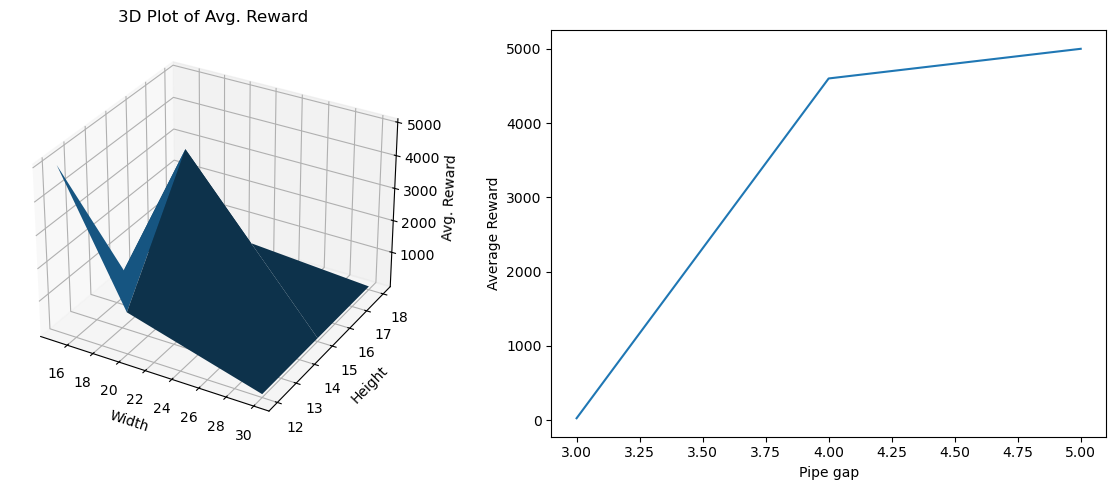

In [24]:
env_sweep_results_df = pd.read_csv("env-sweep-monte-carlo-simple-env.csv")
std_pipe_env_sweep_results_df = env_sweep_results_df[env_sweep_results_df.pipe_gap == 4]
std_map_env_sweep_results_df = env_sweep_results_df[
    (env_sweep_results_df.width == 20) & (env_sweep_results_df.height == 15)
]

def plot_env_params(data, ax, title="3D Plot"):
    def get_Z(width, height):
        mask = (data["width"] == width) & (data["height"] == height)
        return data[mask]["avg_reward"].values[0] if mask.any() else 0

    width_range = np.sort(data["width"].unique())
    height_range = np.sort(data["height"].unique())
    X, Y = np.meshgrid(width_range, height_range)

    Z = np.array([[get_Z(width, height) for width in width_range] for height in height_range])

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1)
    ax.set_xlabel("Width")
    ax.set_ylabel("Height")
    ax.set_zlabel("Avg. Reward")
    ax.set_title(title)


fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection="3d")
plot_env_params(
    std_pipe_env_sweep_results_df,
    ax1,
    title="3D Plot of Avg. Reward"
)

ax2 = fig.add_subplot(122)
ax2.plot(std_map_env_sweep_results_df.pipe_gap, std_map_env_sweep_results_df.avg_reward)
ax2.set_xlabel("Pipe gap")
ax2.set_ylabel("Average Reward")

plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, "env-sweep-sarsa-test-simple-env"))
plt.show()